# Crafting _Evasion Attacks_ with `Keras` & `Tensorflow`

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**Adversarial machine learning (`AML`) is a subfield of machine learning that focuses on developing algorithms and techniques that can withstand and respond to adversarial attacks.** 

**Adversarial attacks are a type of cyber attack where an attacker deliberately manipulates data inputs to ML models with the aim of causing them to produce incorrect outputs.** 

**`AML` aims to improve the robustness and security of ML models by identifying vulnerabilities and developing countermeasures to mitigate the impact of adversarial attacks. A range of techniques have been developed for `AML`, including `adversarial training` (_training models on adversarial examples_), and `defensive distillation` (_creating a distilled version of a model that is resistant to adversarial attacks_).**

**`AML` is an active area of research, as ML models continue to be deployed in a wide range of applications where they may be vulnerable to attack.**

**In this notebook we will be exploring a type of attack called _evasion_. Evasion attacks happen when the network is fed an “_adversarial example_”, i.e., a carefully perturbed input that looks and feels the same as its untampered copy to a human — but that completely throws off the ML model.**

![image](<https://cdn.vox-cdn.com/thumbor/uXLBjJlvk7QNC_HfXbkThG3sHPs=/0x0:652x316/1200x800/filters:focal(274x106:378x210):no_upscale()/cdn.vox-cdn.com/uploads/chorus_image/image/58191589/adversarial_patch_.0.gif>)

**The attacks performed in this notebook are going to be crafted _"by hand"_, using utilities from the Keras/TensorFlow library.**

**The technique used in this notebook is the _Fast Gradient Sign Method_ ([FGSM](https://arxiv.org/abs/1412.6572)), proposed by _[Ian J. Goodfellow](https://arxiv.org/search/stat?searchtype=author&query=Goodfellow%2C+I+J), [Jonathon Shlens](https://arxiv.org/search/stat?searchtype=author&query=Shlens%2C+J), [Christian Szegedy](https://arxiv.org/search/stat?searchtype=author&query=Szegedy%2C+C)_.**

**In this notebook, we will be attacking a CNN trained on the *CIFAR-10 dataset*. The CIFAR-10 dataset ([Canadian Institute For Advanced Research](https://en.wikipedia.org/wiki/Canadian_Institute_for_Advanced_Research "Canadian Institute for Advanced Research")) is a collection of images that are commonly used to train [machine learning](https://en.wikipedia.org/wiki/Machine_learning "Machine learning") and [computer vision](https://en.wikipedia.org/wiki/Computer_vision "Computer vision") algorithms. It is one of the most widely used datasets for machine learning research, containing 60,000 32x32 color images in 10 different classes. The ten classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks (there are 6,000 images of each class).**

**If you do not want to train the model, you can load the trained version in the cell below. But first, you need to download them (instructions in the `models` folder.)**

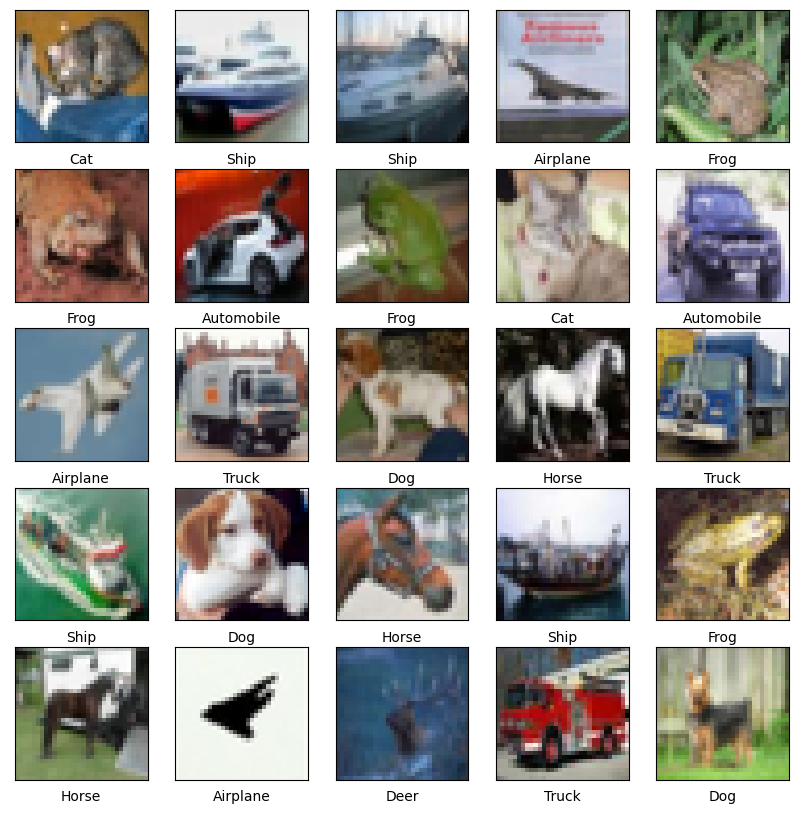

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [1]:
import numpy as np
import tensorflow as tf
from keras import datasets
import matplotlib.pyplot as plt
from keras.utils import np_utils

(_, _), (x_test, y_test) = datasets.cifar10.load_data()

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i][0]])

plt.show()

model = tf.keras.models.load_model('models/Cifar_CNN.h5')
x_test = x_test.astype('float32')
x_test = x_test / 255.
y_test = np_utils.to_categorical(y_test, 10)
test_loss_score, test_acc_score = model.evaluate(x_test, y_test, verbose=0)
model.summary()
print(f'Loss: {round(test_loss_score, 2)}.')
print(f'Accuracy: {round(test_acc_score * 100, 2)} %.')

**Now let's write a function to return labels, predictions and images (feel free to write a better one).** 🙃

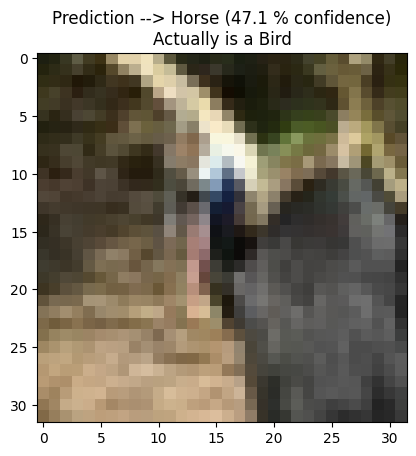

In [2]:
def predict_image(x_test, y_test, sample):
    img_tensor = np.expand_dims(x_test[sample], axis=0)
    pred = [round(num, 3) for num in list(model.predict(img_tensor, verbose=0)[0])]
    plt.figure()
    plt.imshow(x_test[sample])
    plt.title(
        f'Prediction --> {class_names[np.array(pred).argmax()]} ({round(max(pred) * 100, 2)} % confidence)\nActually is a {class_names[y_test[sample].argmax()]}')
    return plt.show()

predict_image(x_test, y_test, np.random.randint(0, 9999))

**Now, we will choose a random sample, and use the class `tf.keras.losses.CategoricalCrossentropy` to create a loss function. We will also record the class index of this specific sample.**

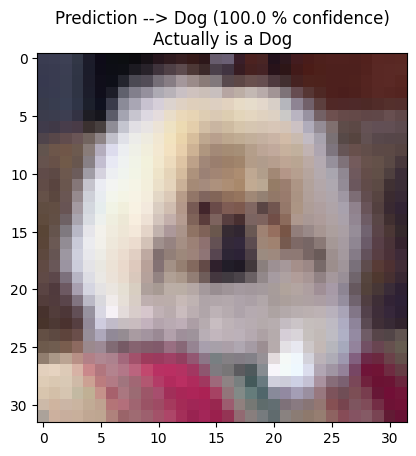

1/1 [==============================] - 0s 19ms/step


In [3]:

sample = np.random.randint(0, 9999)
predict_image(x_test, y_test, sample)
img_tensor = np.expand_dims(x_test[sample], axis=0)
image_probs = model.predict(img_tensor)
class_index = np.argmax(image_probs[0])

loss_object = tf.keras.losses.CategoricalCrossentropy()



**We will use this loss function (_rather than serving as a supervision signal for updating the parameters of a neural network_), in combination with the class `tf.GradientTape()` to create an image (perturbation) that generates the largest possible loss (here we are moving the gradient in the direction in which the loss increases, i.e., gradient ascent) with respect to a specific class.** 

**And that is what the _Fast Sign Gradient Method_ is all about. In essence, `FGSM` is to add the noise (not random noise) whose direction is the same as the gradient of the cost function with respect to the data.**

**All this will be encapsulated by a function called `create_adversarial_pattern`.**

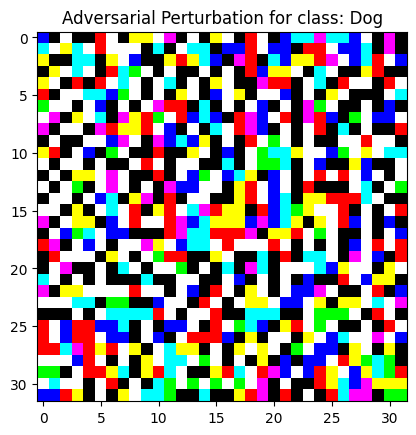

In [4]:

def create_adversarial_pattern(input_image, input_label):
    """
    Computes the adversarial perturbation of an input image using the 
    given model and loss function.

    Parameters:
        input_image (tf.Tensor): The input image for which to 
            compute the adversarial perturbation.
        input_label (tf.Tensor): The true label of the input image.
        
    Returns:
        tf.Tensor: The signed gradient of the loss with respect to 
        the input image, which represents the direction in which 
        the input image should be perturbed in order to increase the loss.
    """
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad


label = tf.one_hot(class_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(
    tf.convert_to_tensor(img_tensor, dtype=tf.float32), label)
adversarial_perturbation = (perturbations[0] * 0.5 + 0.5).numpy()
plt.figure()
plt.imshow(adversarial_perturbation)
plt.title(f'Adversarial Perturbation for class: {class_names[class_index]}')
plt.show()

**Now, we combine our `perturbation` with the `original image` to generate a misclassification. _We will add more and more of the perturbation to the image to see the change in label prediction._**

**The degree to which we add the adversarial perturbation is controlled by the epsilon parameter ($\epsilon$). Attackers generally focus on generating a misclassification with as little $\epsilon$ as possible.**

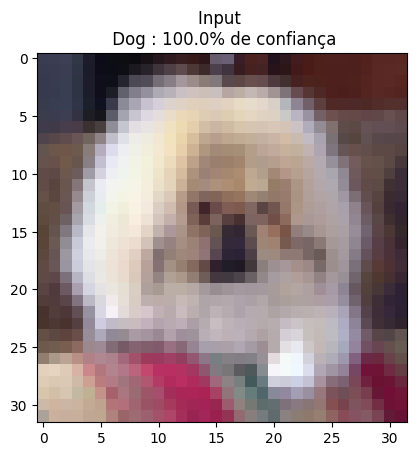

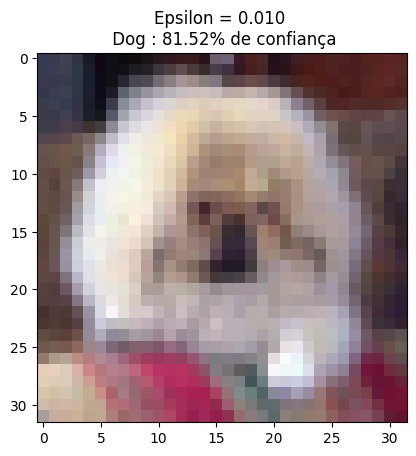

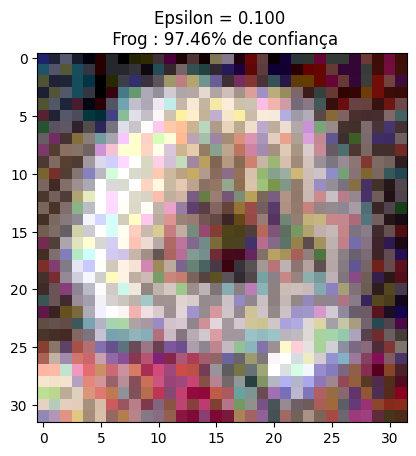

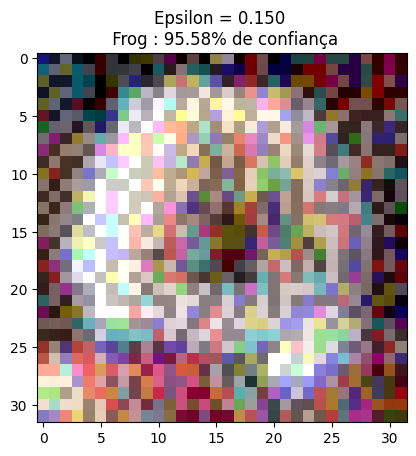

In [8]:
def display_images(img_tensor, description):
    image_probs = model.predict(
        tf.convert_to_tensor(img_tensor, dtype=tf.float32), verbose=0)
    class_confidence = image_probs.max()
    class_index = np.argmax(image_probs[0])
    plt.figure()
    plt.imshow(img_tensor[0])
    plt.title('{} \n {} : {}% de confiança'.format(description,
                                                   class_names[class_index], round(class_confidence * 100, 2)))
    plt.show()


epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = img_tensor + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i])

**Some other adversarial examples crafted against the `MobileNetV2` model can be found in the `Adversaries` folder. You can load this model directly from the Keras library, weights and all!** 🙃

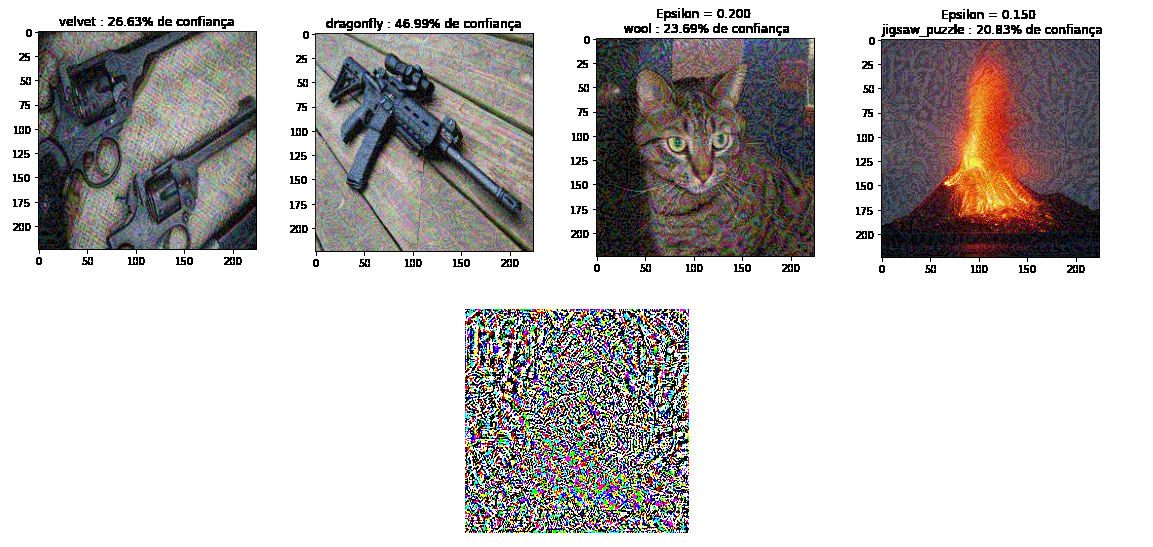

In [1]:
from IPython.display import Image
display(Image(filename=r'adversaries/mobilevnet2_adversaries.png'))

**Adversarial attacks are a real problem in ML. Rifles should not be classified as dragonflies or ponies in any real computer vision circustance/application. 🚫**

----

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).